In [1]:
from asterixdb.asterixdb import AsterixConnection
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community
%matplotlib inline

In [2]:
con = AsterixConnection(server='http://localhost', port=19002)

# Graph construction (fake claims)

In [3]:
data = con.query('''
    USE FactMap;

    SELECT uid,

        (SELECT VALUE count(u.post.subreddit)
        FROM s) as num_posts,

        (SELECT u.post.subreddit, u.post.title, u.post.author, u.post.domain,
        unix_time_from_datetime_in_secs(u.post.created_utc) as created_utc 
        FROM s) as post,

        (SELECT DISTINCT 
        u.review.tagsNamed,
        unix_time_from_datetime_in_secs(datetime(u.review.reviewDate)) as reviewDate,
        unix_time_from_datetime_in_secs(datetime(u.review.claimDate)) as claimDate 
        FROM s) as claim
    FROM fuzzyurljoin u
    WHERE review.reviewRating.isFake = True
    GROUP BY review.uid, claimDate, reviewDate
    GROUP AS s;
    ''').results

Process edges and edge weights

In [4]:
G = nx.Graph()

for match in data:    
    for i in range(len(match['post'])):
        s1 = match['post'][i]['subreddit']
        
        for j in range(i+1, len(match['post'])):
            s2 = match['post'][j]['subreddit']
            
            if s1 == s2:  # avoid self-links (multiple posts to same subreddit)
                continue
            
            if G.has_edge(s1, s2):
                G[s1][s2]['weight'] += 1
            else:
                G.add_edge(s1, s2, weight=1)
                
for match in data:
    for sub in match['post']:
        if not G.has_node(sub['subreddit']): # get unconnected nodes
            G.add_node(sub['subreddit'])

Process node betweenness centrality

In [5]:
btwn = nx.betweenness_centrality(G)
nx.set_node_attributes(G, btwn, name='betweenness')

Process edge tags (tag: frequency)

In [6]:
tags = dict()

for match in data:
    keywords = list(set([k['keyword'] for k in match['claim'][0]['tagsNamed']]))
    
    for i in range(len(match['post'])):
        s1 = match['post'][i]['subreddit']
        
        for j in range(i+1, len(match['post'])):
            s2 = match['post'][j]['subreddit']
            
            if s1 == s2:  # avoid self-links (multiple posts to same subreddit)
                continue
            
            pair = tuple(sorted((s1, s2)))  # ensure consistent ordering
            if pair not in tags.keys():
                tags[pair] = dict()
                
            for tag in keywords:
                if tag not in tags[pair].keys():
                    tags[pair][tag] = 1
                else:
                    tags[pair][tag] += 1

nx.set_edge_attributes(G=G, values=tags, name='tags')

Output to .gexf and process the rest in Gephi

In [7]:
# nx.write_gexf(G, 'fakenet.gexf')

# Louvain modularity

https://github.com/taynaud/python-louvain

Import processed gexf from Gephi

In [8]:
G_fake = nx.read_graphml('fakenet_gephi.graphml')

In [9]:
groups = dict()

for node in list(G_fake.nodes(data=True)):
    sub = node[0]
    cluster = node[1]['Cluster']
    if not cluster in groups.keys():
        groups[cluster] = [sub]
    else:
        groups[cluster].append(sub)

In [10]:
cluster, count = [], []
for k in sorted(groups, key=lambda k: len(groups[k]), reverse=True):
    cluster.append(k)
    count.append(len(groups[k]))

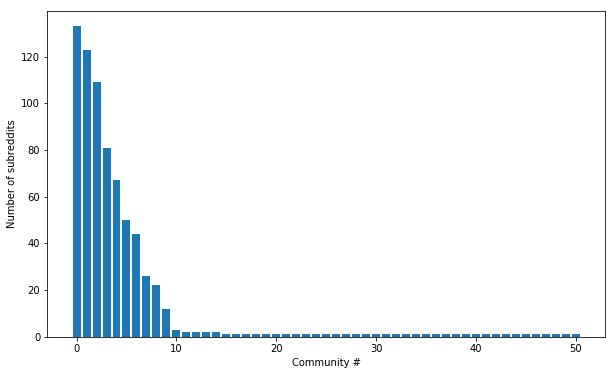

In [11]:
plt.figure(figsize=(10,6))
plt.bar(cluster, count)
plt.xlabel("Community #")
plt.ylabel("Number of subreddits")
# plt.savefig("./louvain_bar.png", bbox_inches='tight')
plt.show()

Compute modularity (range [-1,1]):

In [12]:
# find total degree of nodes in the group
def k_c(G, group):
    k_c = 0
    for node in group:
        k_c += G.degree()[node]
    return k_c

# find number of edges where both nodes are in group
def L_c(G, group):
    L_c = 0
    for edge in G.edges():
        nodes = set(edge)
        if group.issuperset(nodes):
            L_c += 1
    return L_c

# compute modularity using equation 9.12
def M(graph, groups):
    modularity = 0
    L = float(len(graph.edges()))
    for group in groups:
        Lc = L_c(graph, group)
        kc = k_c(graph, group)
        Mc = Lc/L - (kc/(2.0*L))**2.0
        modularity += Mc
    return modularity

In [13]:
louvain = [set(vals) for vals in groups.values()]

print("Modularity using Louvain:", M(G_fake, louvain))

Modularity using Louvain: 0.48853137937669877


Very good partitioning (well over 0)!

## Wordclouds over community tags (internal only)

In [14]:
from collections import Counter
import ast

intratags = dict()  # only tags from edges within community
intertags = dict()  # also tags from edges out of community

for e in G_fake.edges(data=True):
    sub1 = e[0]
    sub2 = e[1]
    t = ast.literal_eval(e[2]['tags'])
    c1 = G_fake.node[sub1]['Cluster']
    c2 = G_fake.node[sub2]['Cluster']
    
    if c1 == c2:
        if c1 not in intratags.keys():
            intratags[c1] = Counter(t)
        else:
            intratags[c1] = intratags[c1] + Counter(t)
    else:
        if c1 not in intertags.keys():
            intertags[c1] = Counter(t)
        else:
            intertags[c1] = intertags[c1] + Counter(t)

        if c2 not in intertags.keys():
            intertags[c2] = Counter(t)
        else:
            intertags[c2] = intertags[c2] + Counter(t)

Note, only 15 of the 51 groups contain edges between more than one subreddit. The remaining 36 groups are disconnected singletons with only 1 subreddit in it.

In [15]:
len(intratags)

15

Now to visualize the main groups:

In [16]:
from wordcloud import WordCloud
from PIL import Image

def random_color_func(h, s):
    def color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
        l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
        return "hsl({}, {}%, {}%)".format(h, s, l)
    return color_func

def cloud(tags, h, s, savefile=None, image_mask=None, stopwords=[]):
    if image_mask:
        image_mask = np.array(Image.open("plots/masks/"+image_mask))
        wc = WordCloud(width=1280, height=720, 
                       mask = image_mask,
                       background_color="rgba(255, 255, 255, 0)", 
                       mode="RGBA")
    else:
        wc = WordCloud(width=1280, height=720, 
                       background_color="rgba(255, 255, 255, 0)", 
                       mode="RGBA")
    wc.fit_words({k: np.log(v+1) for k,v in tags.items() if k not in stopwords})
    wc.recolor(color_func=random_color_func(h, s), random_state=2)
#     if savefile is not None:
#         wc.to_file("./plots/wordclouds/" + savefile)
    return wc.to_image()

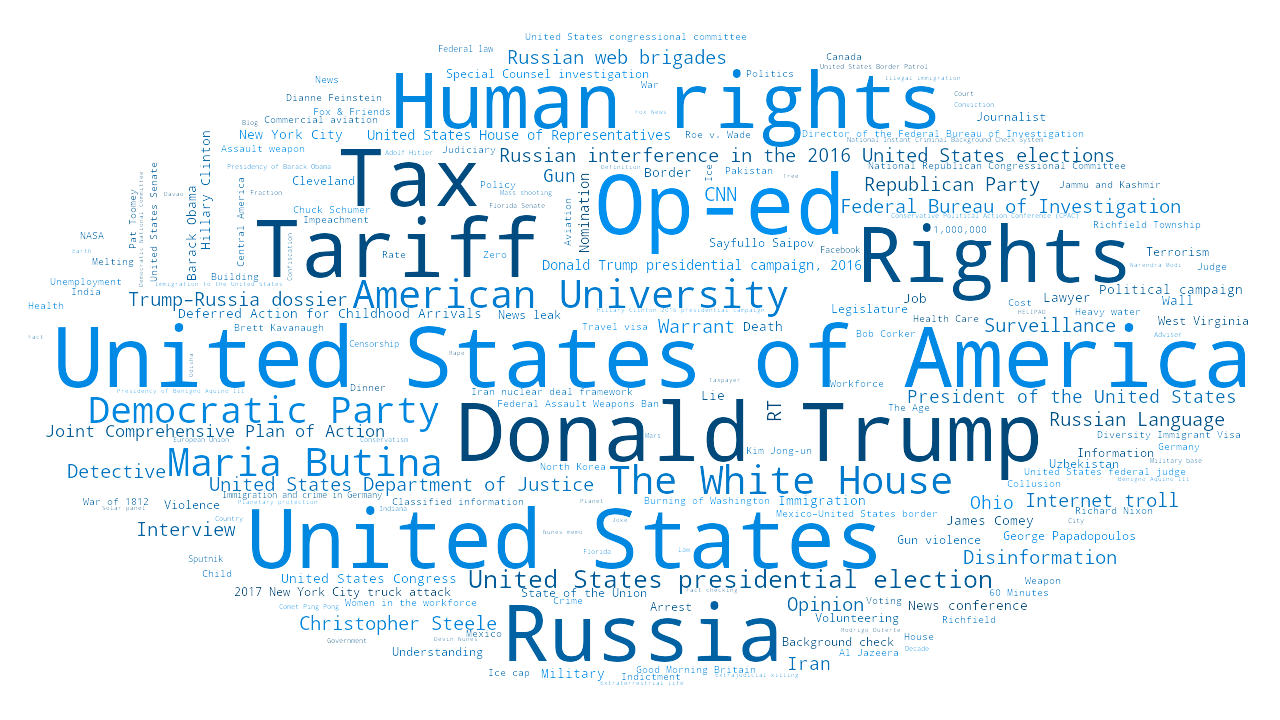

In [17]:
# Trump, human rights, and Russia
cloud(intratags[0], 204, 100, savefile="masked_c0.png", image_mask="c0.png")
cloud(intratags[0], 204, 100, savefile="c0.png", image_mask="oval.png")

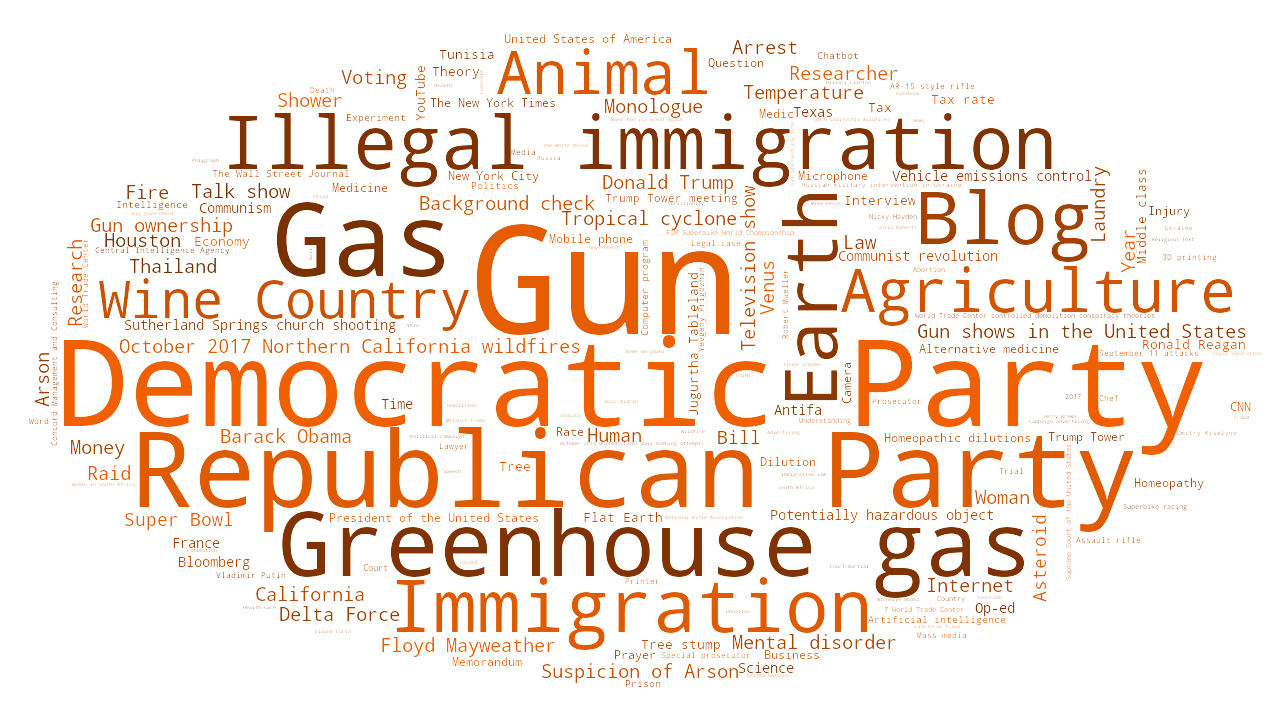

In [18]:
# climate, guns, and immigration
stopwords = ['Percentage']
cloud(intratags[1], 24, 100, savefile="masked_c1.png", image_mask="c1.png", stopwords=stopwords)
cloud(intratags[1], 24, 100, savefile="c1.png", image_mask="oval.png", stopwords=stopwords)

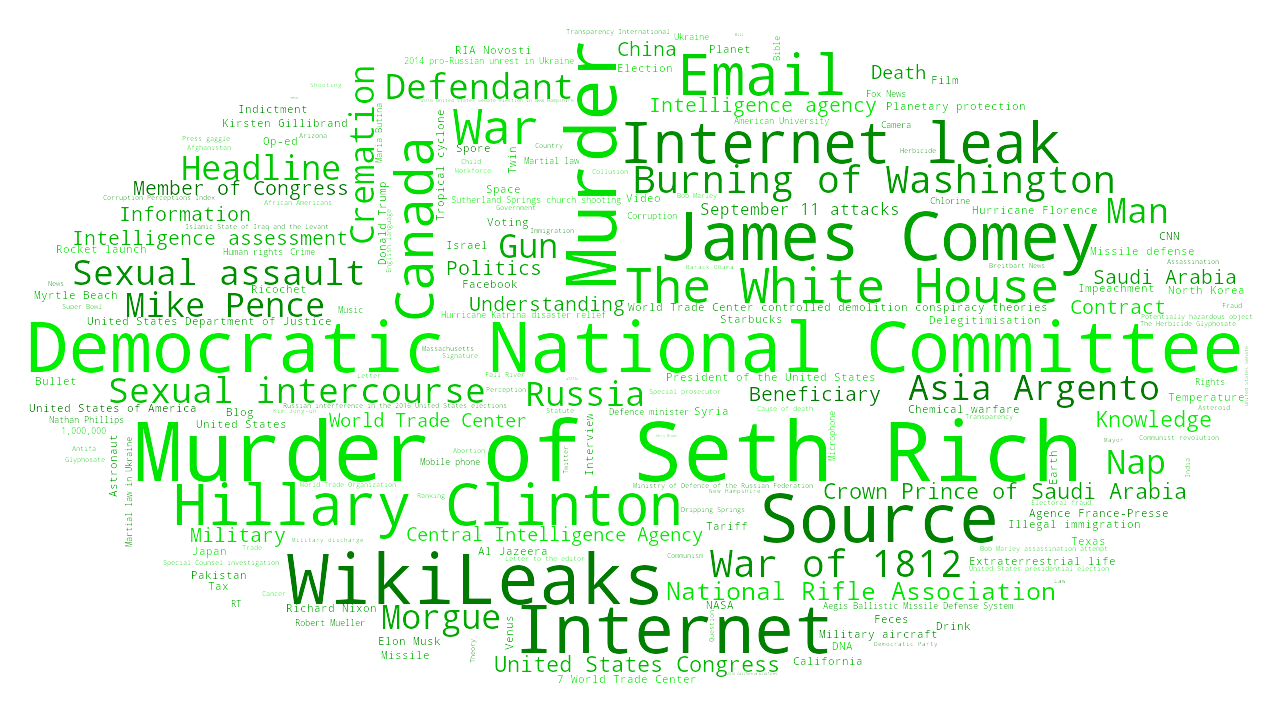

In [19]:
# wikileaks, conspiracies, and scandals
cloud(intratags[2], 120, 100, savefile="masked_c2.png", image_mask="c2.png")
cloud(intratags[2], 120, 100, savefile="c2.png", image_mask="oval.png")

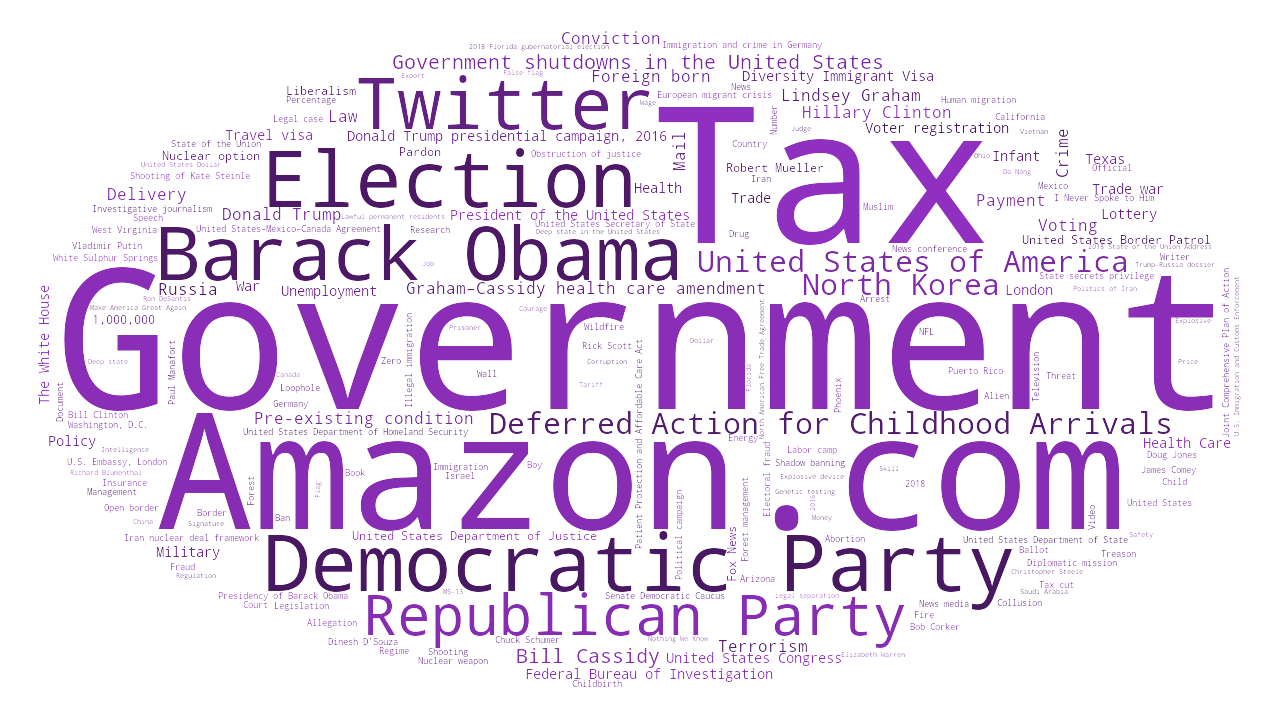

In [20]:
# amazon taxes, DACA
cloud(intratags[3], 280, 60, savefile="masked_c3.png", image_mask="c3.png")
cloud(intratags[3], 280, 60, savefile="c3.png", image_mask="oval.png")

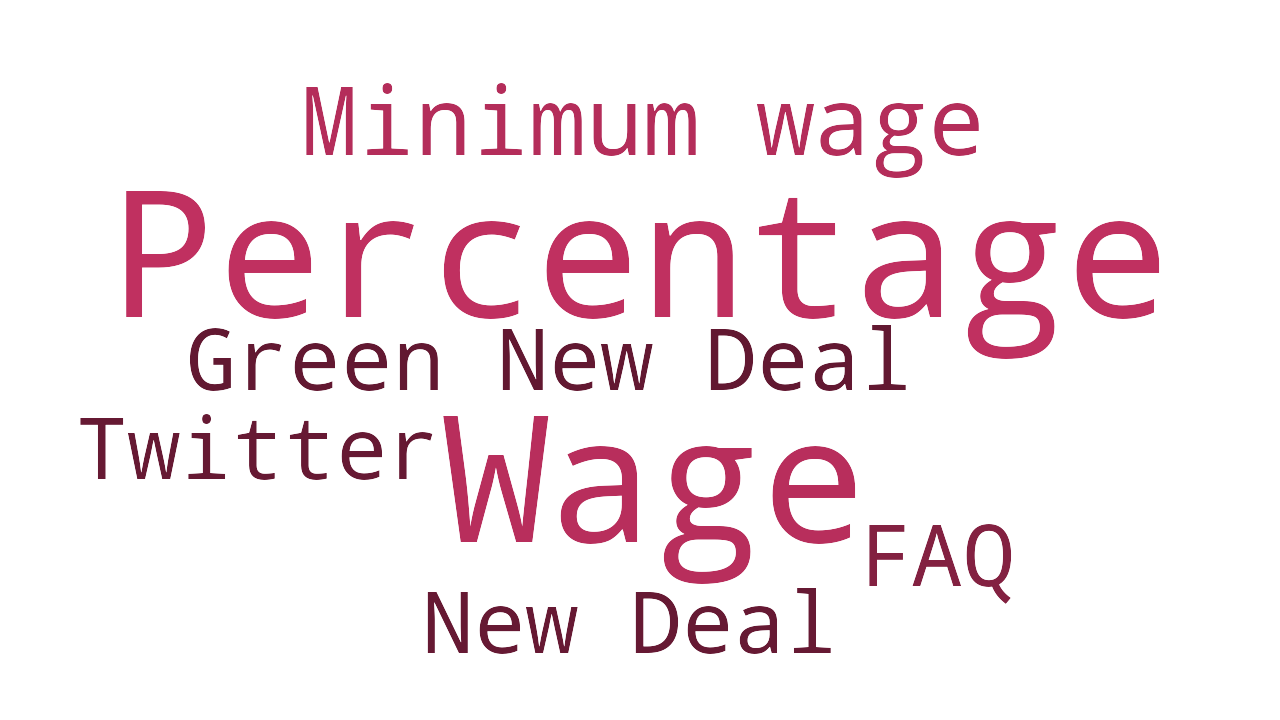

In [21]:
# minimum wages
cloud(intratags[4], 340, 60, savefile="masked_c4.png", image_mask="c4.png")
cloud(intratags[4], 340, 60, savefile="c4.png", image_mask="oval.png")

This one looks like a particularly thin community based only on a few stories. Let's inspect:

In [22]:
response = con.query('''
    USE FactMap;

    SELECT uid, 
    (SELECT DISTINCT f.r.claimReviewed FROM x) as review,
    (SELECT f.p.title, f.p.subreddit FROM x) as posts
    FROM fuzzyurljoin f
    WHERE r.reviewRating.isFake = True
    AND
    (contains(p.subreddit, "ForSanders")
    OR
    contains(p.subreddit, "ForBernie")
    OR p.subreddit="GreenNewDeal")
    GROUP BY r.uid
    GROUP AS x;
    ''').results

print("Number of unique (false) claims posted in community:", len(response))
print()

for r in response:
    print(r['review'][0]['claimReviewed'] + '\n')

Number of unique (false) claims posted in community: 2

“There are multiple doctored GND [Green New Deal] resolutions and FAQs floating around. There was also a draft version that got uploaded + taken down. There’s also draft versions floating out there. Point is, the real one is our submitted resolution, H.Res. 109.”

Raising the federal minimum wage to $15 "would give more than 40 million low-wage workers a raise, more than 25 percent of the U.S. workforce."



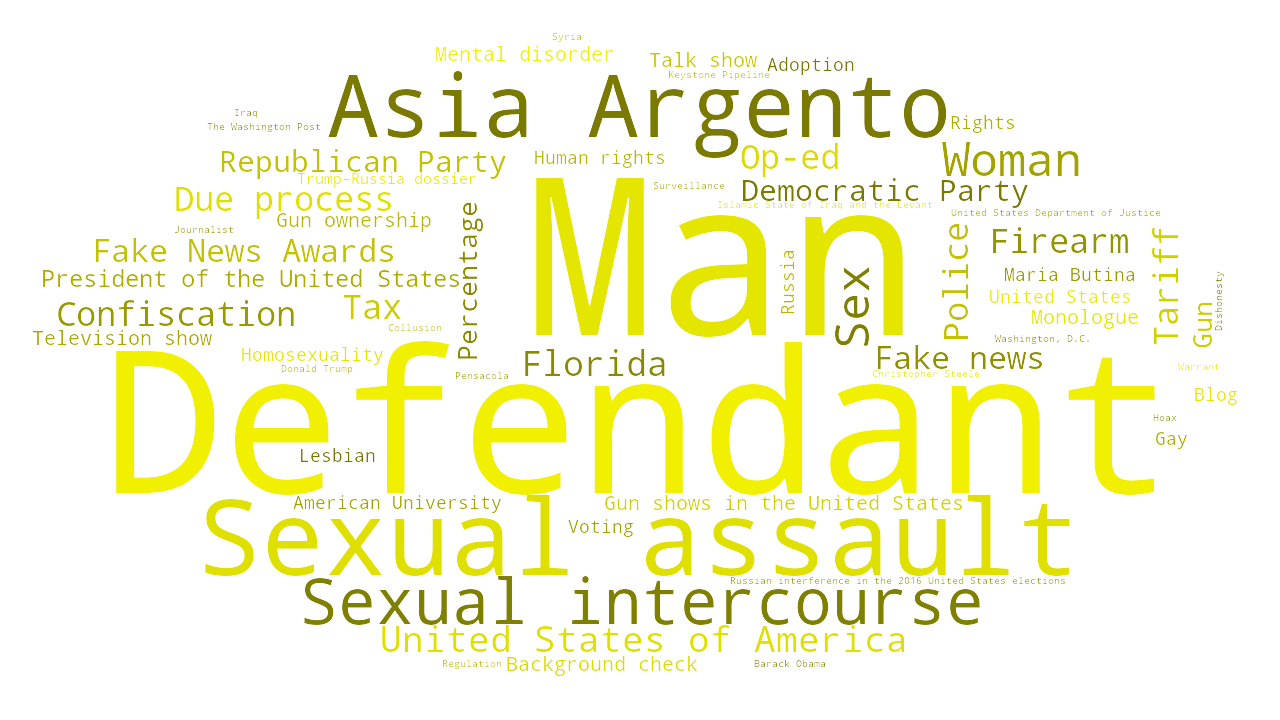

In [23]:
# sexual assault, LGBT, legal hustice
cloud(intratags[5], 60, 100, savefile="masked_c5.png", image_mask="c5.png")
cloud(intratags[5], 60, 100, savefile="c5.png", image_mask="oval.png")

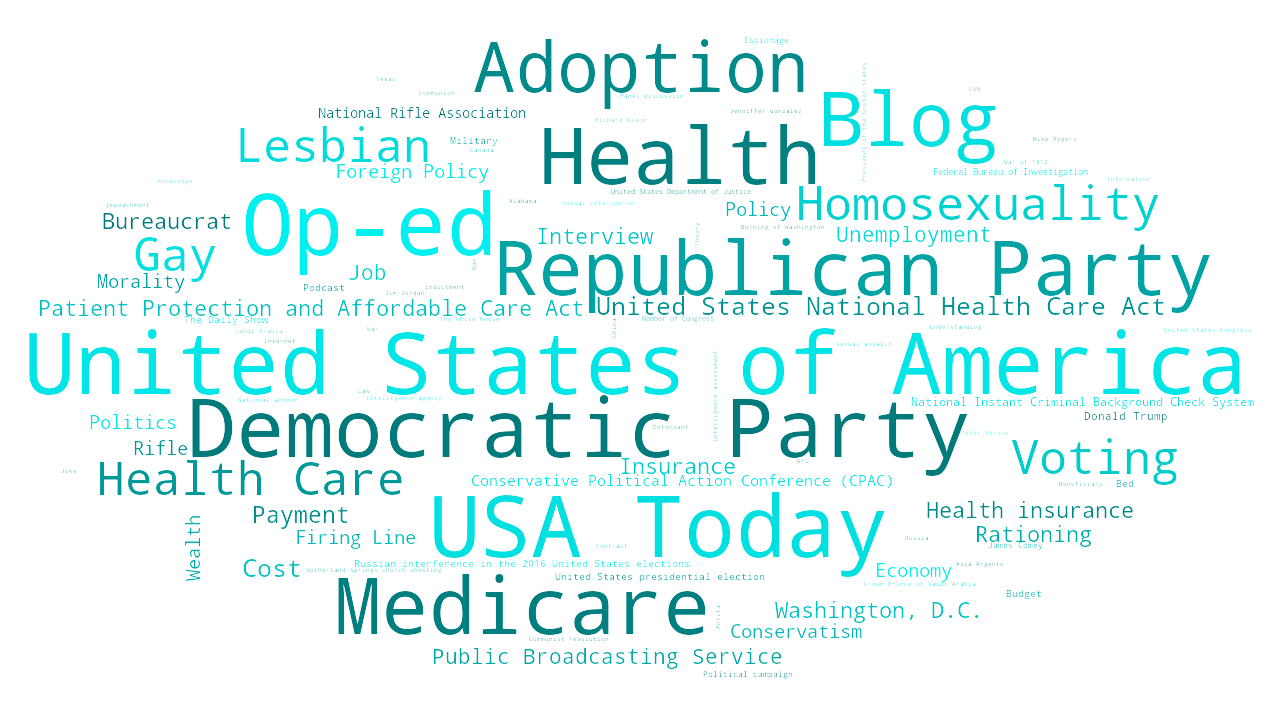

In [24]:
# health care and LGBT rights
cloud(intratags[6], 180, 100, savefile="masked_c6.png", image_mask="c6.png")
cloud(intratags[6], 180, 100, savefile="c6.png", image_mask="oval.png")

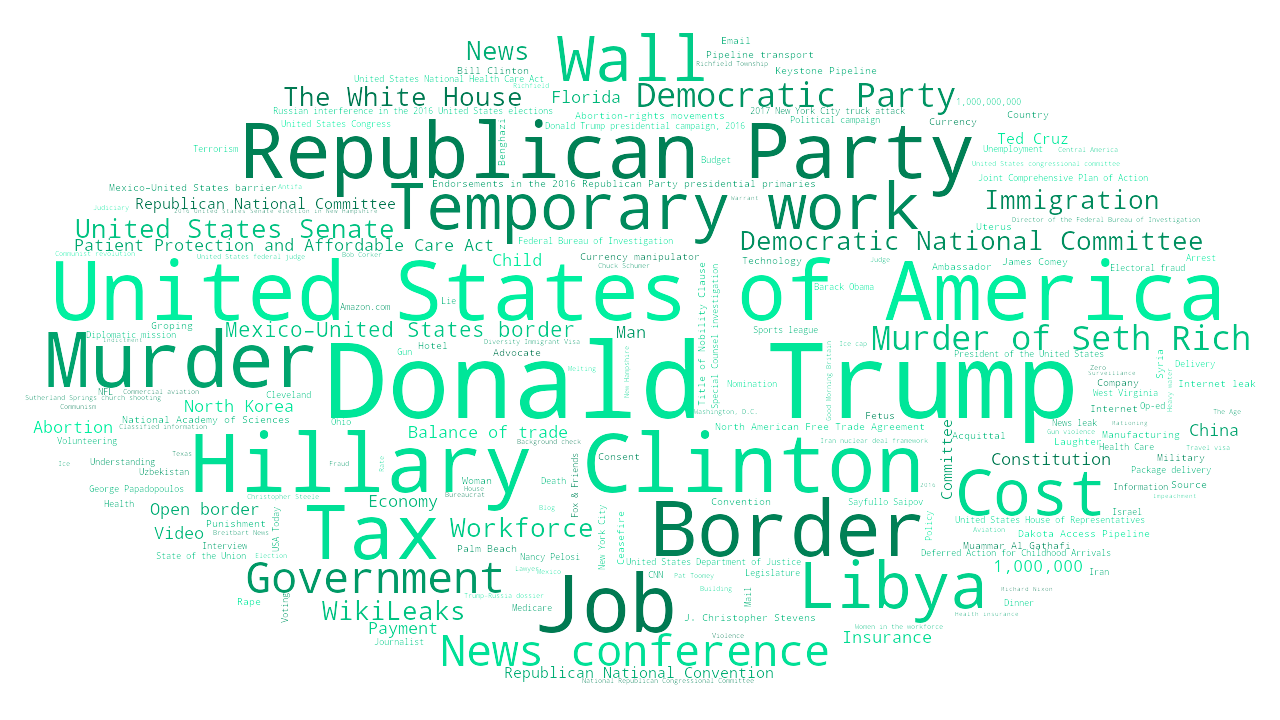

In [25]:
# Border control/wall and jobs/work force
stopwords = ['Fact', 'Fact checking', 'FactCheck.org']
cloud(intratags[7], 160, 100, savefile="masked_c7.png", image_mask="c7.png", stopwords=stopwords)
cloud(intratags[7], 160, 100, savefile="c7.png", image_mask="oval.png", stopwords=stopwords)

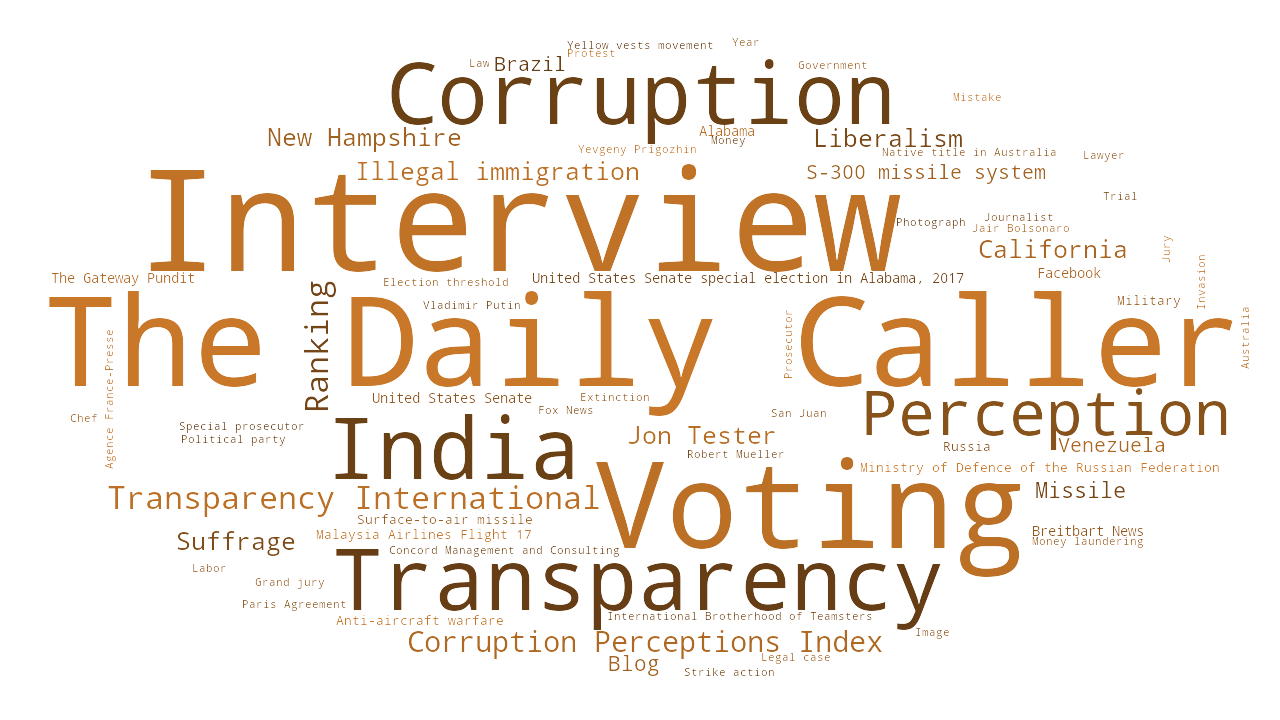

In [26]:
# India, corruption, and transparency
cloud(intratags[8], 30, 67, savefile="masked_c8.png", image_mask="c8.png")
cloud(intratags[8], 30, 67, savefile="c8.png", image_mask="oval.png")

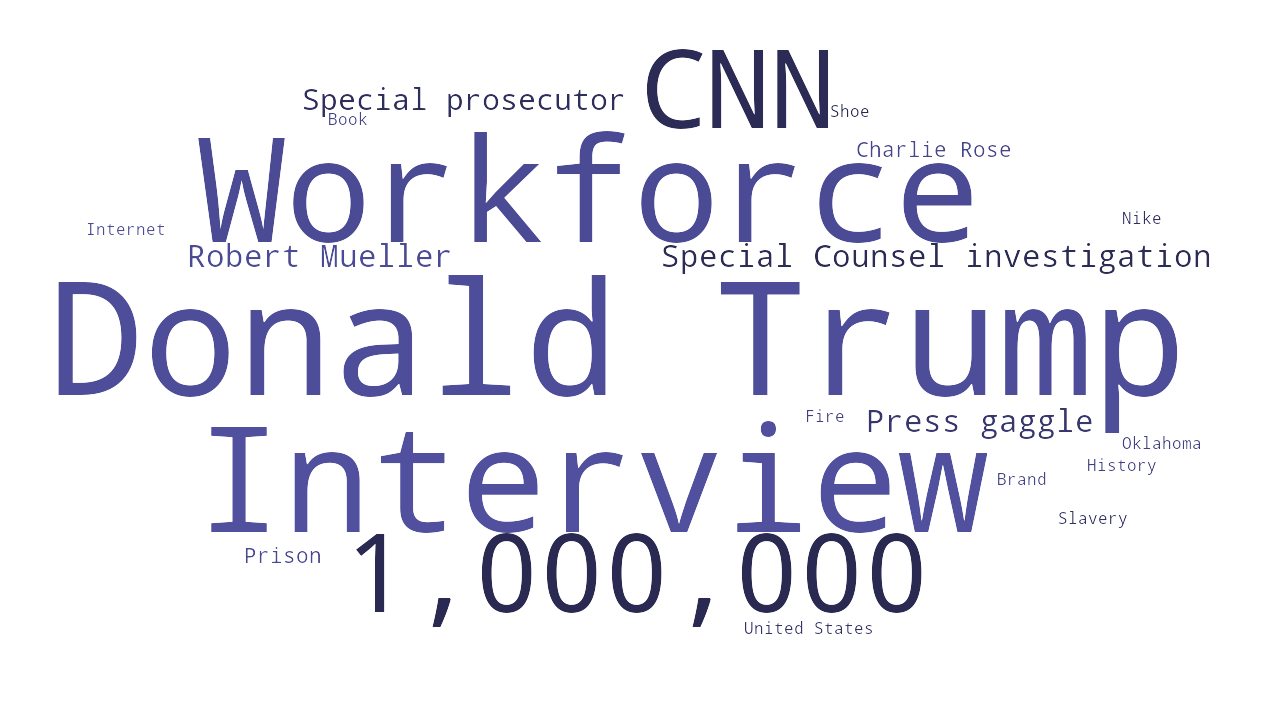

In [27]:
# Mueller, Trump, investigation
cloud(intratags[9], 240, 33, savefile="masked_c9.png", image_mask="c9.png")
cloud(intratags[9], 240, 33, savefile="c9.png", image_mask="oval.png")

## Wordclouds over community subreddits

In [28]:
sub2deg = dict(nx.degree(G_fake))

In [29]:
group2sub2deg = dict() # {group: {subreddit: degree in whole network}}

for group, subs in groups.items():
    if group not in group2sub2deg.keys():
        group2sub2deg[group] = dict()
    
    for sub in subs:
        group2sub2deg[group][sub] = sub2deg[sub]

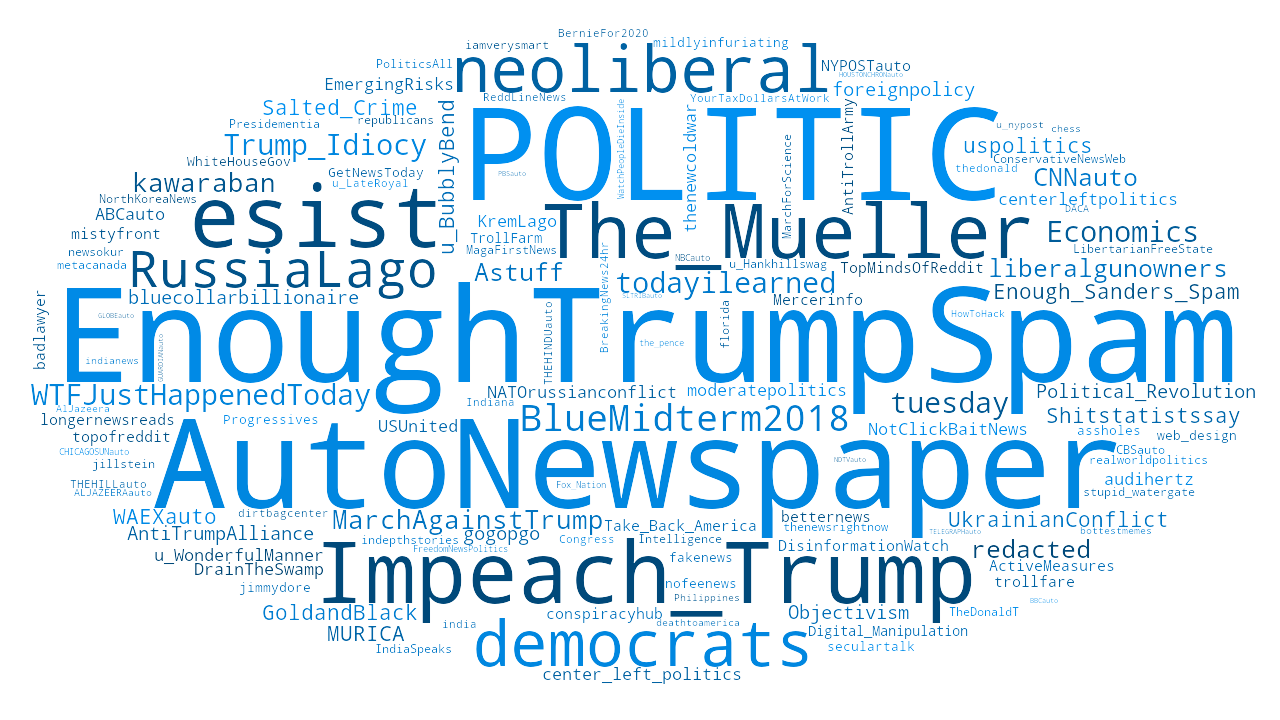

In [30]:
# Trump, human rights, and Russia
cloud(group2sub2deg[0], 204, 100, savefile="subs_c0.png", image_mask="oval.png")

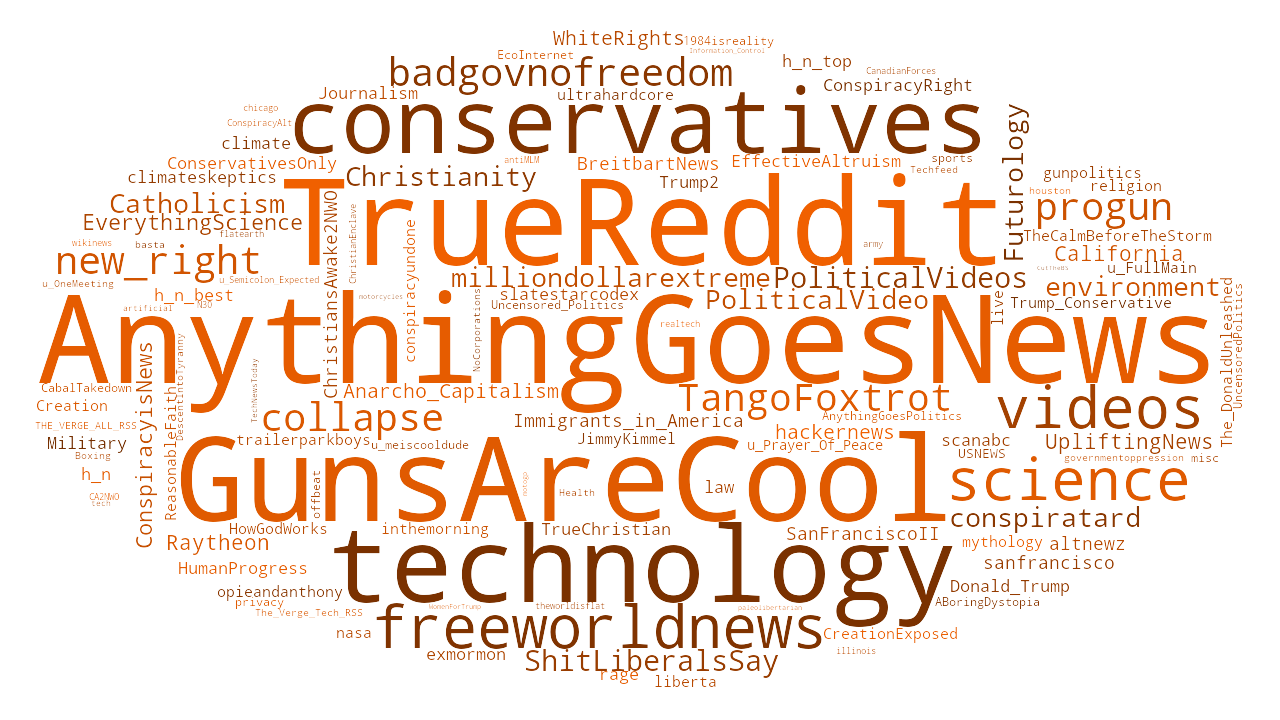

In [31]:
# climate, guns, and immigration
cloud(group2sub2deg[1], 24, 100, savefile="subs_c1.png", image_mask="oval.png")

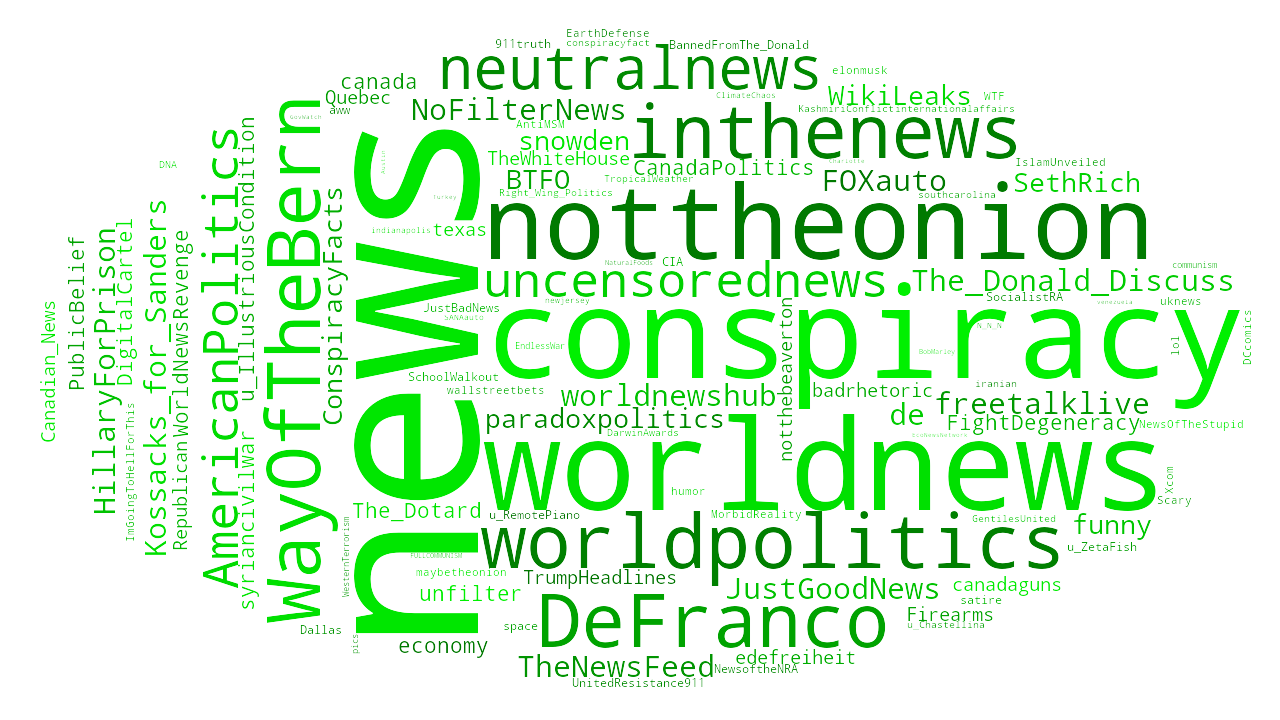

In [32]:
# wikileaks, conspiracies, and scandals
cloud(group2sub2deg[2], 120, 100, savefile="subs_c2.png", image_mask="oval.png")

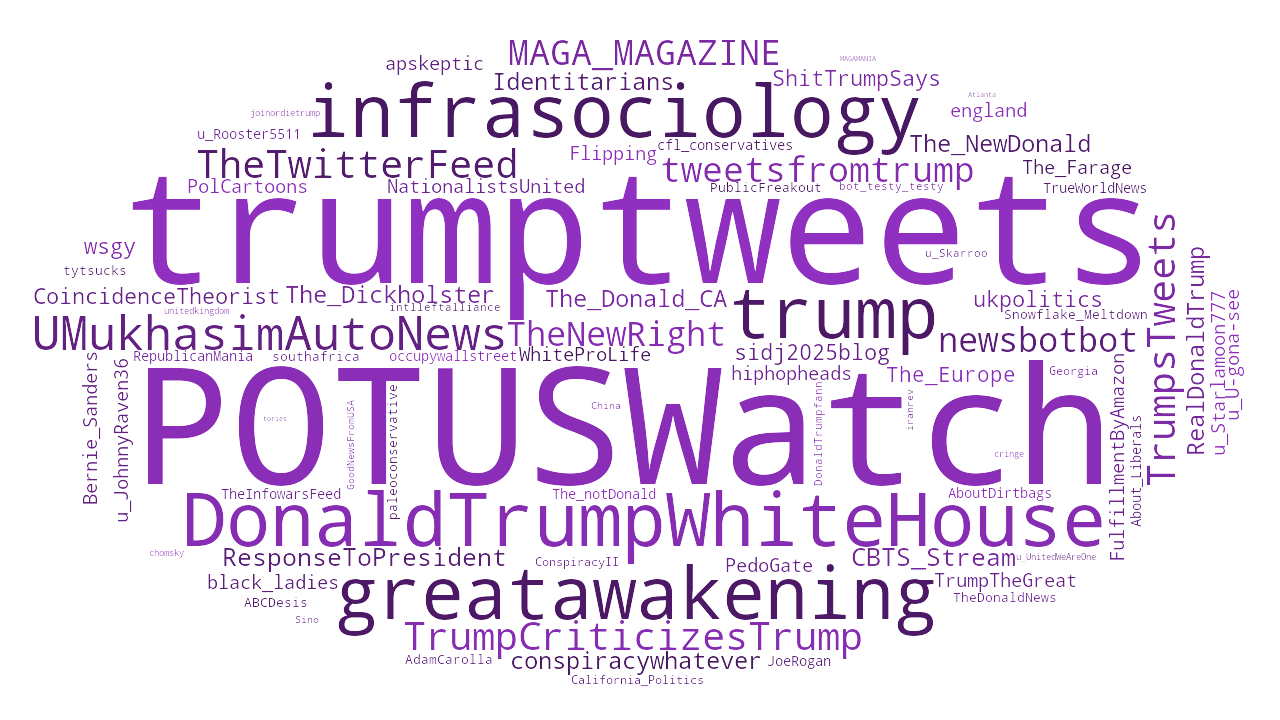

In [33]:
# amazon taxes, DACA
cloud(group2sub2deg[3], 280, 60, savefile="subs_c3.png", image_mask="oval.png")

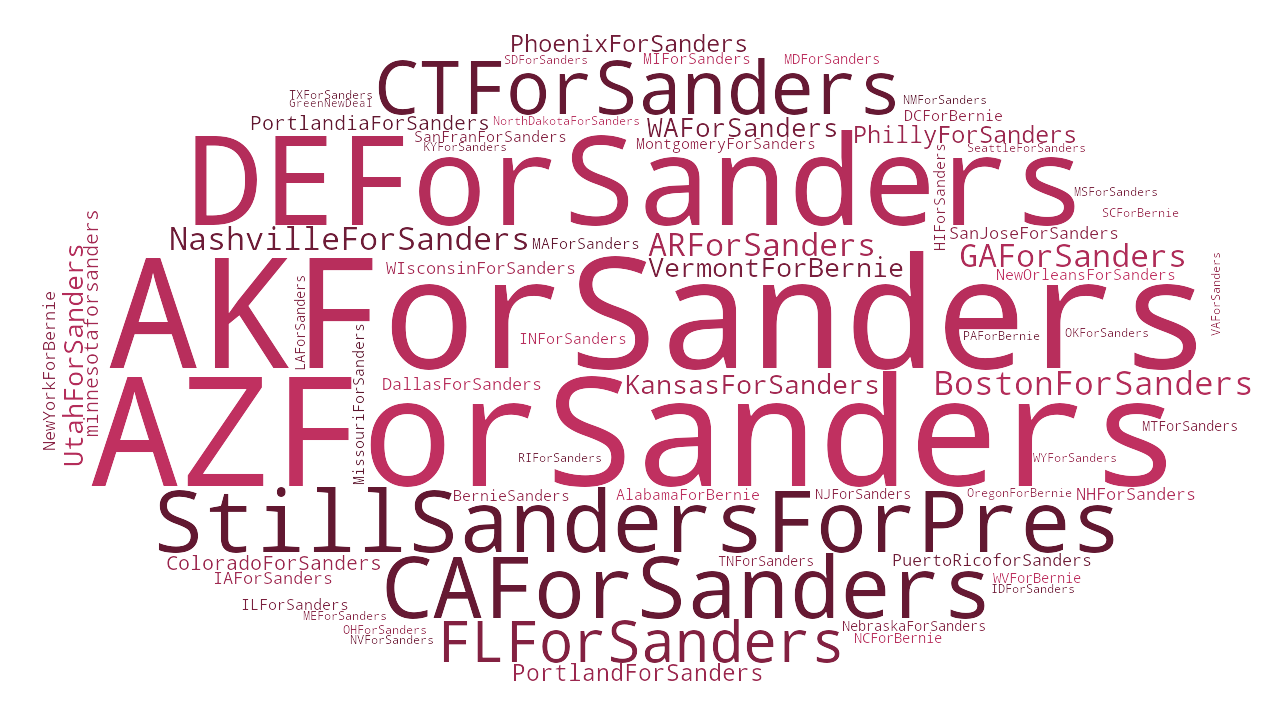

In [34]:
# minimum wages
cloud(group2sub2deg[4], 340, 60, savefile="subs_c4.png", image_mask="oval.png")

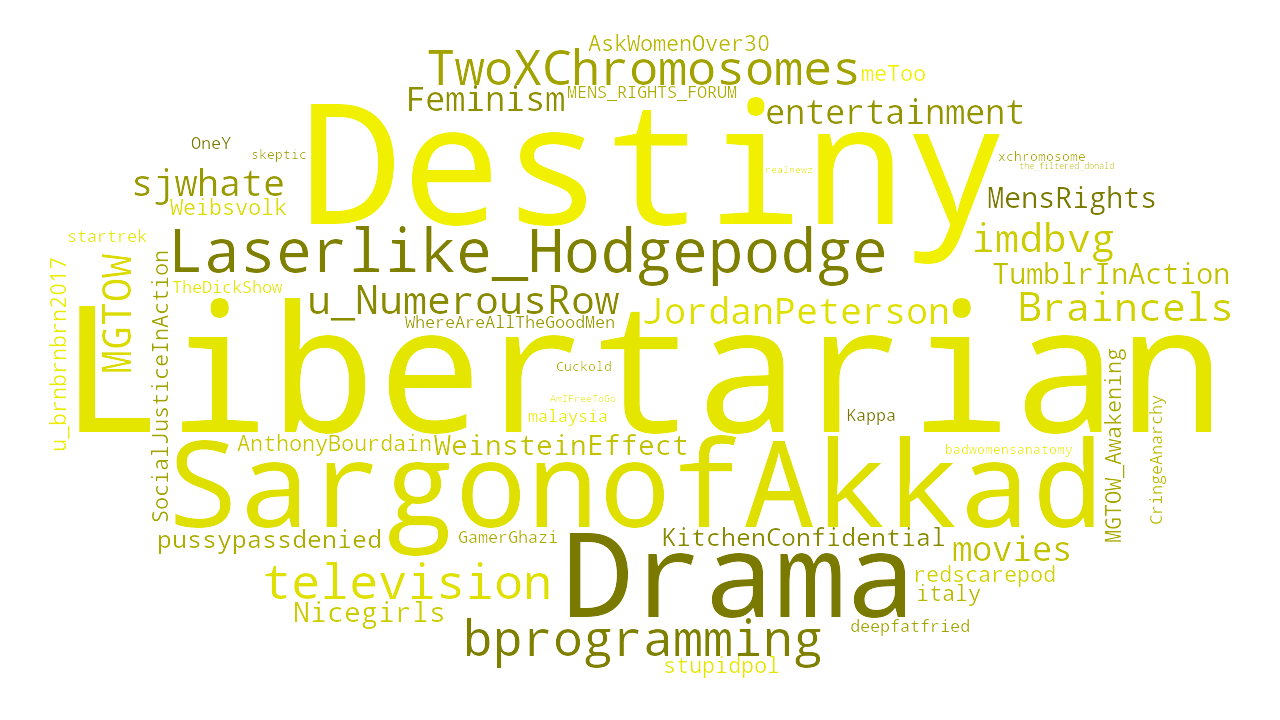

In [35]:
# sexual assault, LGBT, legal hustice
cloud(group2sub2deg[5], 60, 100, savefile="subs_c5.png", image_mask="oval.png")

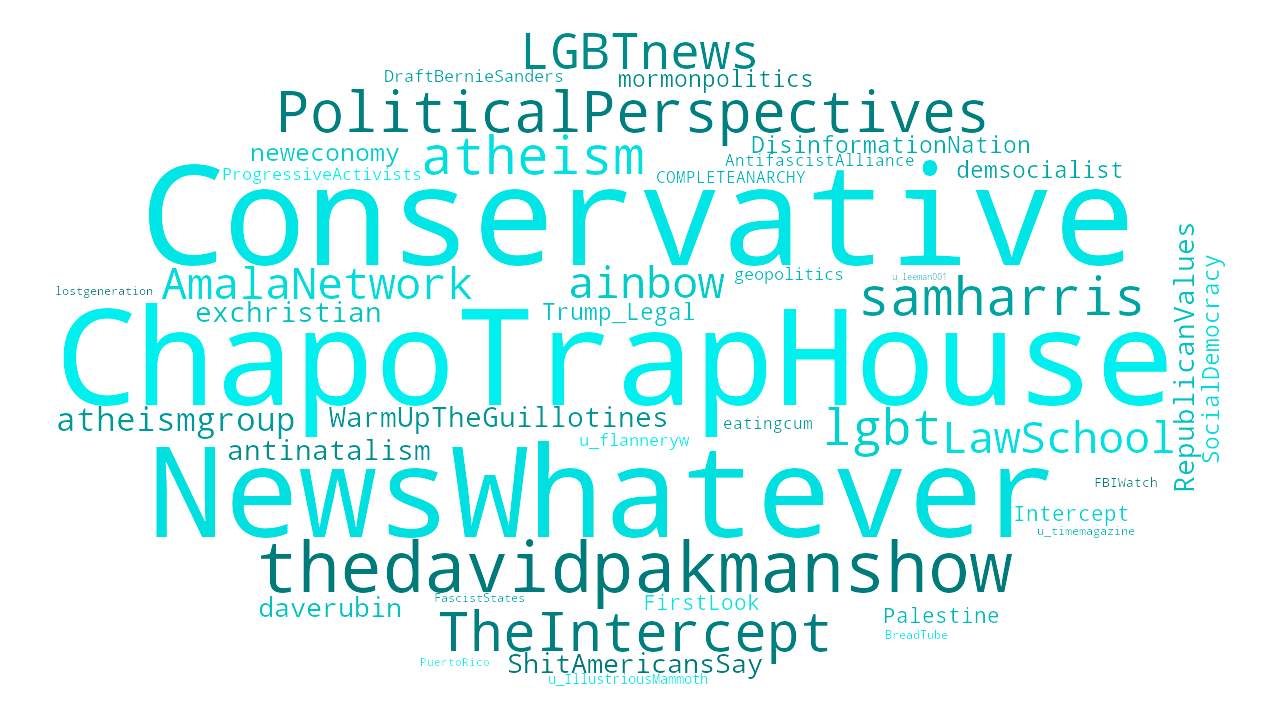

In [36]:
# health care and LGBT rights
cloud(group2sub2deg[6], 180, 100, savefile="subs_c6.png", image_mask="oval.png")

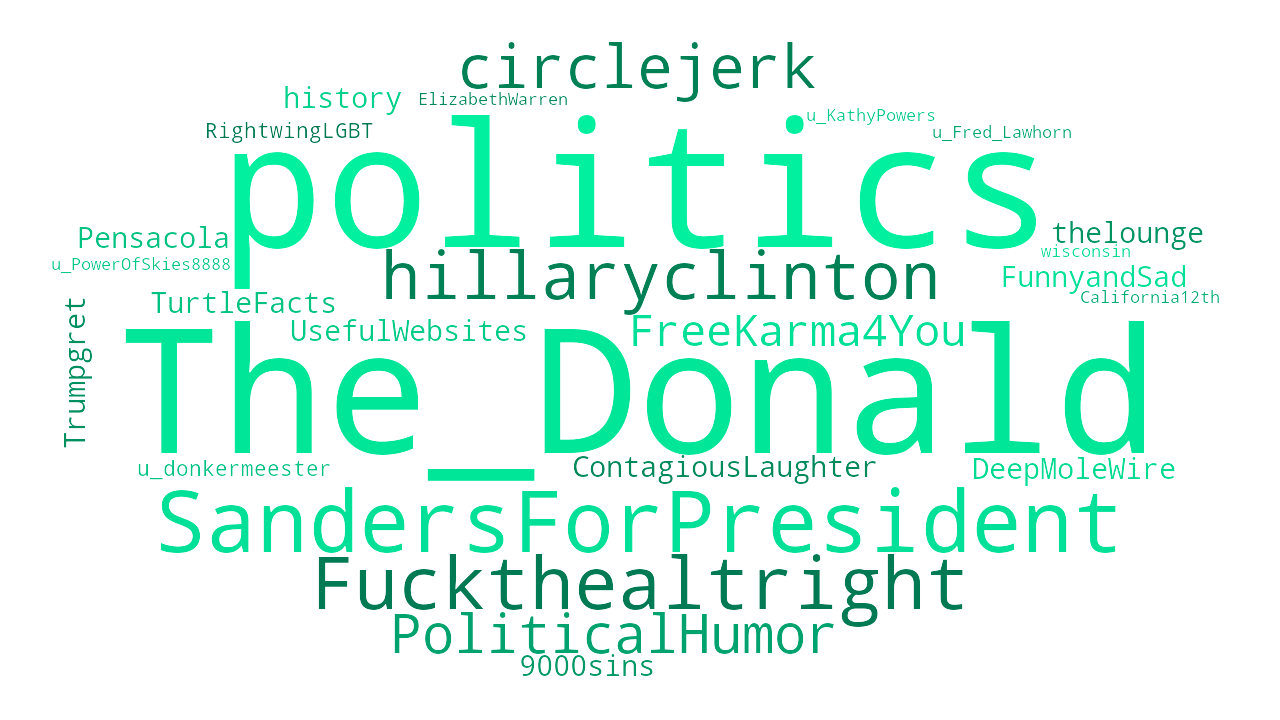

In [37]:
# Border control/wall and jobs/work force
cloud(group2sub2deg[7], 160, 100, savefile="subs_c7.png", image_mask="oval.png")

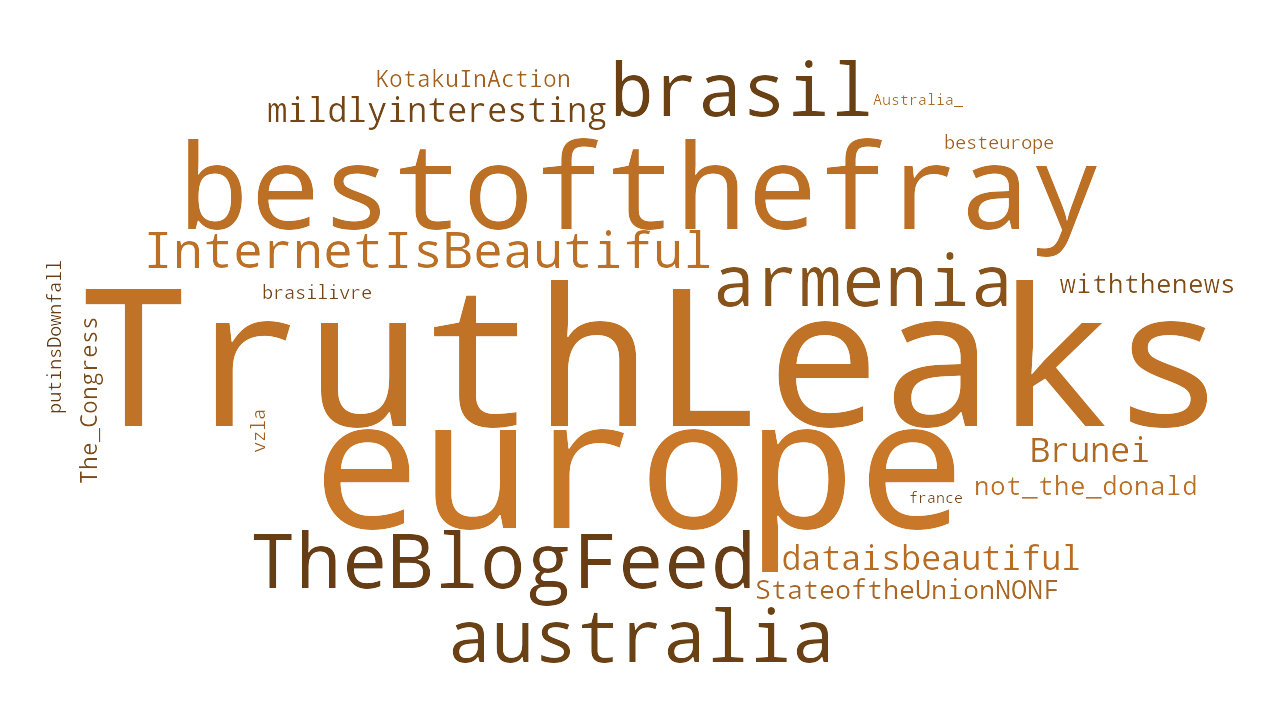

In [38]:
# India, corruption, and transparency
cloud(group2sub2deg[8], 30, 67, savefile="subs_c8.png", image_mask="oval.png")

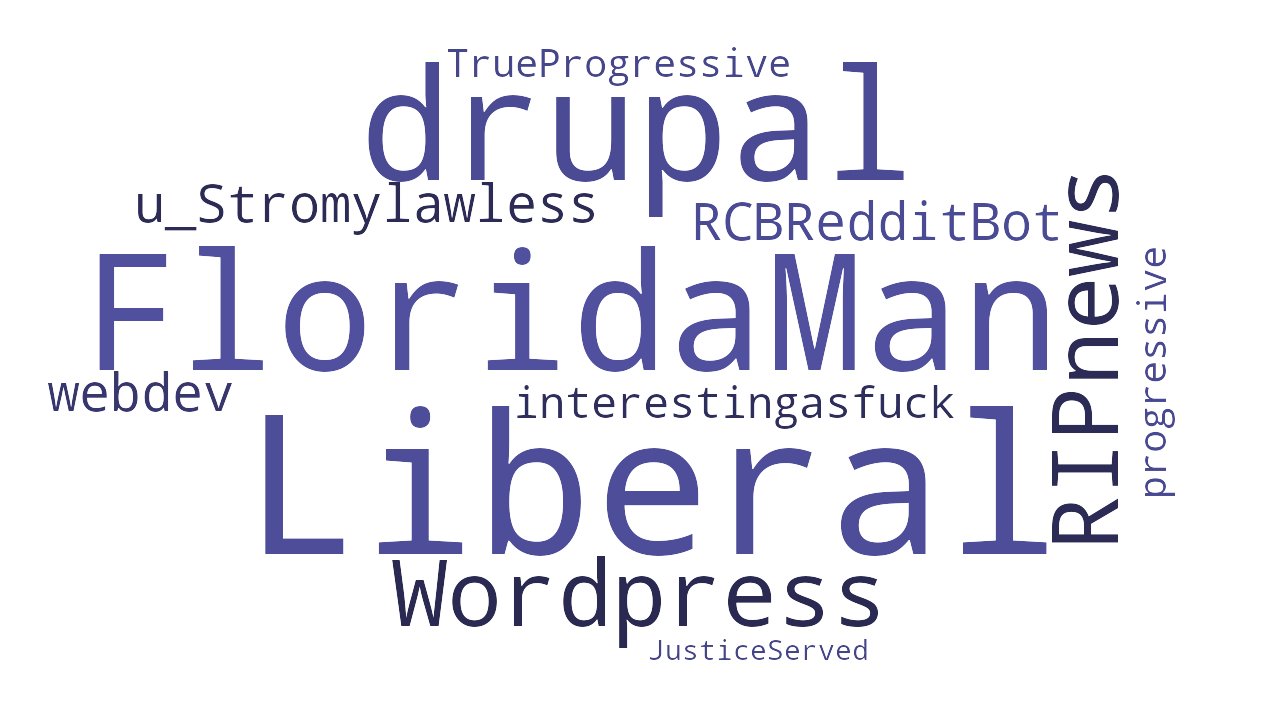

In [39]:
# Mueller, Trump, investigation
cloud(group2sub2deg[9], 240, 33, savefile="subs_c9.png", image_mask="oval.png")

# Graph construction (reviews)

Note: Only care about reviews on fake items (corresponding to the previous graph)!

In [40]:
data = con.query('''
    USE FactMap;

    SELECT uid,

        (SELECT VALUE count(u.p.subreddit)
        FROM s) as num_posts,

        (SELECT u.p.subreddit, u.p.title, u.p.author, u.p.domain,
        unix_time_from_datetime_in_secs(u.p.created_utc) as created_utc 
        FROM s) as post,

        (SELECT DISTINCT 
        u.r.tagsNamed,
        unix_time_from_datetime_in_secs(datetime(u.r.reviewDate)) as reviewDate,
        unix_time_from_datetime_in_secs(datetime(u.r.claimDate)) as claimDate 
        FROM s) as claim
    FROM facturljoin u
    WHERE r.reviewRating.isFake = True
    GROUP BY r.uid, claimDate, reviewDate
    GROUP AS s;
    ''').results

print("Number of review matches on fake items:", len(data))

Number of review matches on fake items: 6108


Process edges and edge weights

In [41]:
G_fact = nx.Graph()

for match in data:    
    for i in range(len(match['post'])):
        s1 = match['post'][i]['subreddit']
        
        for j in range(i+1, len(match['post'])):
            s2 = match['post'][j]['subreddit']
            
            if s1 == s2:  # avoid self-links (multiple posts to same subreddit)
                continue
            
            if G_fact.has_edge(s1, s2):
                G_fact[s1][s2]['weight'] += 1
            else:
                G_fact.add_edge(s1, s2, weight=1)
                
for match in data:
    for sub in match['post']:
        if not G_fact.has_node(sub['subreddit']): # get unconnected nodes
            G_fact.add_node(sub['subreddit'])

Process node betweenness centrality

In [42]:
btwn = nx.betweenness_centrality(G_fact)
nx.set_node_attributes(G_fact, btwn, name='betweenness')

Process edge tags (tag: frequency)

In [43]:
tags = dict()

for match in data:
    keywords = list(set([k['keyword'] for k in match['claim'][0]['tagsNamed']]))
    
    for i in range(len(match['post'])):
        s1 = match['post'][i]['subreddit']
        
        for j in range(i+1, len(match['post'])):
            s2 = match['post'][j]['subreddit']
            
            if s1 == s2:  # avoid self-links (multiple posts to same subreddit)
                continue
            
            pair = tuple(sorted((s1, s2)))  # ensure consistent ordering
            if pair not in tags.keys():
                tags[pair] = dict()
                
            for tag in keywords:
                if tag not in tags[pair].keys():
                    tags[pair][tag] = 1
                else:
                    tags[pair][tag] += 1

nx.set_edge_attributes(G=G_fact, values=tags, name='tags')

Assign groups from FakeNet (default group 100 if no match)

In [44]:
default_group = 100
default = {n: default_group for n in G_fact.nodes}
nx.set_node_attributes(G_fact, default, name='fakenet_cluster')

In [45]:
sub2group = {v: key for key, val in groups.items() for v in val}

nx.set_node_attributes(G_fact, sub2group, name='fakenet_cluster')

Output to .gexf and process the rest in Gephi

In [46]:
# nx.write_gexf(G_fact, 'factnet.gexf')

---

# Echo chambers

In [61]:
import pandas as pd
from pySankey import sankey

Create capped dict converting subreddits from both fakenet and factnet to group number. Cap for group numbers 10 or larger (too small to care).

In [62]:
sub2group = {node[0]: node[1]['Cluster'] for node in list(G_fake.nodes(data=True))}
sub2group.update({node[0]: node[1]['fakenet_cluster'] for node in list(G_fact.nodes(data=True))})
sub2group = {sub: group if group < 10 else 10 for sub, group in sub2group.items()}

Join subreddits posting fake news item with subreddits posting corresponding corrected article (if such a post exists, otherwise just give the fake sub).

In [123]:
data = con.query('''
    USE FactMap;

    SELECT  f.r.uid,
            f.r.claimReviewed,
            f.p.subreddit as fakesub,
            p.subreddit as factsub
    FROM    fuzzyurljoin f
            LEFT OUTER JOIN
            posts p
            ON 
            f.r.reviewUrl = p.url
    WHERE   f.r.reviewRating.isFake = true;
    ''').results

len(data)

10361

In [124]:
sub2group['Uncorrected'] = 11  # group for fake news that were never corrected on reddit
pairs = []

for e in data:
    fake = e['fakesub']
    fact = e['factsub'] if 'factsub' in e.keys() else 'Uncorrected'
    pairs.append([sub2group[fake], sub2group[fact]])
    
df = pd.DataFrame(pairs)
df.columns = ["Fake Community", "Retraction Community"]
df.head()

Fake Community  Retraction Community
0               1                     1
1               1                     1
2               0                     1
3               0                     0
4               7                    11

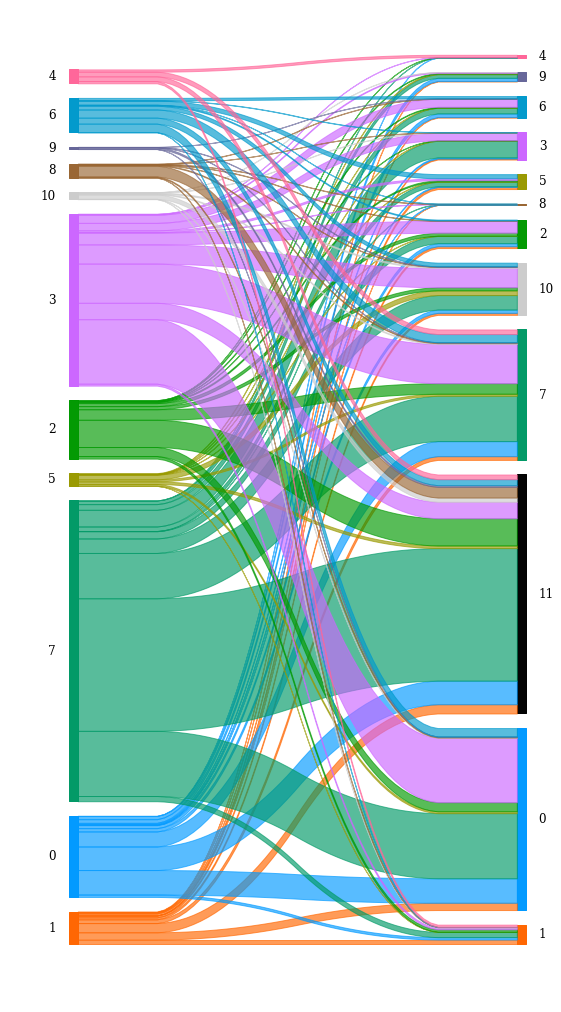

In [125]:
colorDict = {
    0:'#0099ff',
    1:'#ff6600',
    2:'#009900',
    3:'#cc66ff',
    4:'#ff6699',
    5:'#999900',
    6:'#0099cc',
    7:'#009966',
    8:'#996633',
    9:'#666699',
    10:'#cccccc',  # uncategorized
    11:'#000000'   # uncorrected
}

sankey.sankey(
    left=df['Fake Community'], 
    right=df['Retraction Community'], 
    colorDict=colorDict,
    aspect=100,
    fontsize=12
)
plt.gcf().set_size_inches(9, 18)
# plt.savefig("sankey_communities.png", bbox_inches='tight')

By top subreddits posting the most fake news:

In [126]:
subpairs = []

for e in data:
    fake = e['fakesub']
    fact = e['factsub'] if 'factsub' in e.keys() else 'Uncorrected'
    subpairs.append([fake, fact])
    
df_sub = pd.DataFrame(subpairs)
df_sub.columns = ["Fake", "Fact"]
df_sub.head()

Fake              Fact
0    EverythingScience       EcoInternet
1       NoCorporations       EcoInternet
2              CNNauto       gunpolitics
3              CNNauto  liberalgunowners
4  SandersForPresident       Uncorrected

In [127]:
auto = ['AutoNewspaper', 'CBSauto', 'DonaldTrumpWhiteHouse', 'TheTwitterFeed', 
        'trumptweets', 'POTUSWatch', 'trump', 'TrumpsTweets', 'UMukhasimAutoNews',
       'tweetsfromtrump', 'EcoInternet']  # filter out subs with mainly auto-generated posts

top_fake = list(df_sub[~df_sub.Fake.isin(auto)].Fake.value_counts().nlargest(10).index)
print(top_fake)
df_sub_fake = df_sub[df_sub.Fake.isin(top_fake)].copy()

top_fact = list(df_sub_fake.Fact[~df_sub.Fact.isin(auto)].value_counts().nlargest(11).index)
print(top_fact)
df_sub_fake.Fact[~df_sub_fake.Fact.isin(top_fact)] = "Other"

subs = set(df_sub_fake.Fake).union(set(top_fact))
print()
print(subs)

['The_Donald', 'politics', 'circlejerk', 'news', 'EnoughTrumpSpam', 'hillaryclinton', 'Conservative', 'SandersForPresident', 'TrumpCriticizesTrump', 'Fuckthealtright']
['Uncorrected', 'politics', 'uspolitics', 'The_Donald', 'MarchAgainstTrump', 'Impeach_Trump', 'EnoughTrumpSpam', 'NewsWhatever', 'skeptic', 'news', 'Liberal']

{'politics', 'circlejerk', 'SandersForPresident', 'Conservative', 'skeptic', 'MarchAgainstTrump', 'NewsWhatever', 'Uncorrected', 'uspolitics', 'TrumpCriticizesTrump', 'news', 'Impeach_Trump', 'Fuckthealtright', 'EnoughTrumpSpam', 'hillaryclinton', 'Liberal', 'The_Donald'}


By top subreddits posting the most corrected news:

In [128]:
data = con.query('''
    USE FactMap;

    SELECT  f.r.uid,
            f.r.claimReviewed,
            f.p.subreddit as factsub,
            p.subreddit as fakesub
    FROM    facturljoin f
            LEFT OUTER JOIN
            posts p
            ON 
            f.r.claimAuthor.claimURL = p.url
    WHERE   f.r.reviewRating.isFake = true;
    ''').results

len(data)

27106

In [129]:
subpairs = []

for e in data:
    fake = e['fakesub'] if 'fakesub' in e.keys() else 'Not posted'
    fact = e['factsub']
    subpairs.append([fake, fact])
    
df_sub = pd.DataFrame(subpairs)
df_sub.columns = ["Fake", "Fact"]
df_sub.head()

Fake           Fact
0  Not posted   NewsWhatever
1  Not posted     ukpolitics
2  Not posted  AutoNewspaper
3  Not posted           news
4  Not posted       politics

In [130]:
top_fact = list(df_sub.Fact[~df_sub.Fact.isin(auto)].value_counts().nlargest(10).index)
print(top_fact)
df_sub_fact = df_sub[df_sub.Fact.isin(top_fact)].copy()

top_fake = list(df_sub_fact.Fake[~df_sub_fact.Fake.isin(auto)].value_counts().nlargest(10).index)
print(top_fake)
df_sub_fact.Fake[~df_sub_fact.Fake.isin(top_fake)] = "Other"

subnames = subs.union(set(df_sub_fact.Fact)).union(set(top_fake))

['politics', 'uspolitics', 'LiarLiar', 'EnoughTrumpSpam', 'The_Donald', 'Impeach_Trump', 'NewsWhatever', 'MarchAgainstTrump', 'democrats', 'news']
['Not posted', 'The_Donald', 'politics', 'EnoughTrumpSpam', 'esist', 'circlejerk', 'ChapoTrapHouse', 'news', 'todayilearned', 'TrumpCriticizesTrump']


In [150]:
colors = ['#a6cee3','#1f78b4','#b2df8a','#bc80bd','#b15928','#ffed6f',
          '#bebada','#cab2d6','#6a3d9a','#8dd3c7','#fb8072','#33a02c',
          '#80b1d3','#fdb462','#b3de69','#fdbf6f' ,'#ccebc5', '#fb9a99',
          '#ff7f00','#fccde5','#ffffb3','#e31a1c','#ffff99', '#d9d9d9']
colorDict = {sub: col for sub, col in zip(subnames, colors[:len(subnames)]) if sub != 'Uncorrected'}
colorDict.update({'Uncorrected':'#000000', 'Other': '#cccccc', 'Not posted': '#000000'})

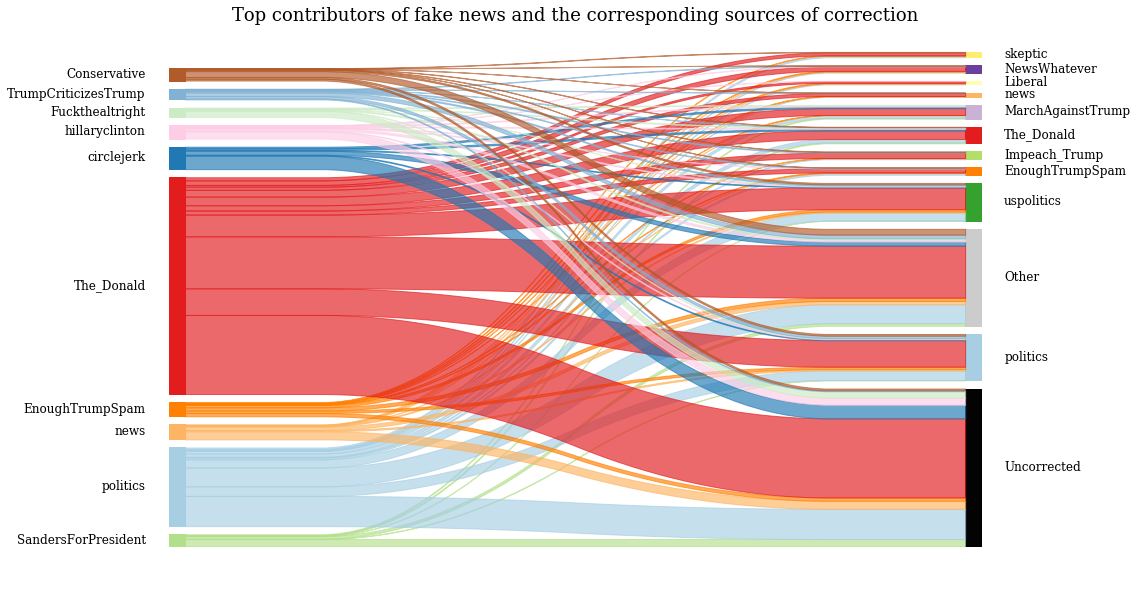

In [151]:
sankey.sankey(
    left=df_sub_fake['Fake'], 
    right=df_sub_fake['Fact'], 
    aspect=100,
    colorDict=colorDict,
    fontsize=12
)
plt.gcf().set_size_inches(16, 10)
plt.title("Top contributors of fake news and the corresponding sources of correction", fontsize=18)
plt.savefig("sankey_fakesubs.png", bbox_inches='tight')
plt.show()

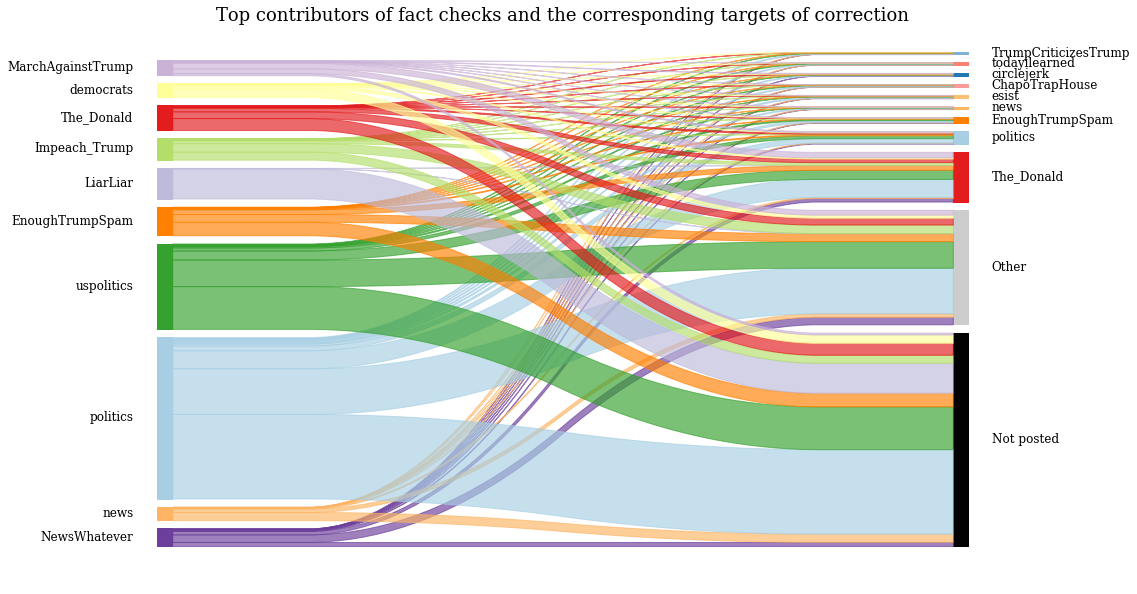

In [152]:
sankey.sankey(
    left=df_sub_fact['Fact'], 
    right=df_sub_fact['Fake'], 
    aspect=100,
    colorDict=colorDict,
    fontsize=12
)
plt.gcf().set_size_inches(16, 10)
plt.title("Top contributors of fact checks and the corresponding targets of correction", fontsize=18)
plt.savefig("sankey_factsubs.png", bbox_inches='tight')
plt.show()

---